# EMA ROCs

John Curtin

## Set up environment

In [ ]:
# handle conflicts
options(conflicts.policy = "depends.ok")

library(tidyverse, quietly = TRUE)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

## Open preds dfs

In [ ]:
preds_week<- read_rds(file.path(path_models, 
                               "outer_preds_1week_0_v5_nested_main.rds"))
preds_day<- read_rds(file.path(path_models, 
                              "outer_preds_1day_0_v5_nested_main.rds"))
preds_hour<- read_rds(file.path(path_models, 
                               "outer_preds_1hour_0_v5_nested_main.rds"))


## Open metrics for text labels of auROC

In [ ]:
metrics_week <- read_csv(file.path(path_models, 
                                   "test_metrics_1week_0_v5_nested.csv"),
                         col_types = cols())
metrics_day <- read_csv(file.path(path_models, 
                                  "test_metrics_1day_0_v5_nested.csv"),
                        col_types = cols())
metrics_hour <- read_csv(file.path(path_models, 
                                   "test_metrics_1hour_0_v5_nested.csv"),
                         col_types = cols())

auROC <- metrics_week |> 
  mutate(model = "week") |> 
  bind_rows(metrics_day |> 
              mutate(model = "day")) |> 
  bind_rows(metrics_hour |> 
              mutate(model = "hour")) |> 
  filter(.metric == "roc_auc") |>
  select(-.metric) |> 
  group_by(model) |> 
  summarize(median = median(.estimate), .groups = "drop") |> 
  mutate(median = round(median, 2)) |> 
  pivot_wider(names_from = model, values_from = median) |> 
  select(week, day, hour)


## Generate ROC Curves

In [ ]:
roc_week <- preds_week |> 
  yardstick::roc_curve(prob_beta, truth = label) |> 
  mutate(model = "1week")
  
roc_day <- preds_day |> 
  yardstick::roc_curve(prob_beta, truth = label) |> 
  mutate(model = "1day")

roc_hour <- preds_hour|> 
  yardstick::roc_curve(prob_beta, truth = label) |> 
  mutate(model = "1hour")

roc_all <- roc_week |> 
  bind_rows(roc_day) |> 
  bind_rows(roc_hour) |> 
  mutate(thres_avg = round(.threshold, 3)) |> 
  group_by(model, thres_avg) |> 
  reframe(sensitivity = mean(sensitivity), specificity =  mean(specificity)) |> 
  mutate(model = factor(model, levels = c("1week", "1day", "1hour"),
                        labels = c("week", "day", "hour")))

auROC_week <- auROC$week |>
  as.character() |>
  str_pad(width = 4, side = "right", pad = "0")

auROC_day <- auROC$day |>
  as.character() |>
  str_pad(width = 4, side = "right", pad = "0")

auROC_hour <- auROC$hour |>
  as.character() |>
  str_pad(width = 4, side = "right", pad = "0")


## ROC Plot Function

In [ ]:
plot_roc <- function(df){
  df |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = model)) +
    geom_path(linewidth = 1.25) +
    geom_abline(lty = 3) +
    coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
    labs(x = "Specificity",
        y = "Sensitivity") +
  scale_x_continuous(breaks = seq(0,1,.25),
    labels = sprintf("%.2f", seq(1,0,-.25)))  +
  scale_color_manual(values = c("orange","green","blue"))
}


## ROC plots for combos of models

Week only

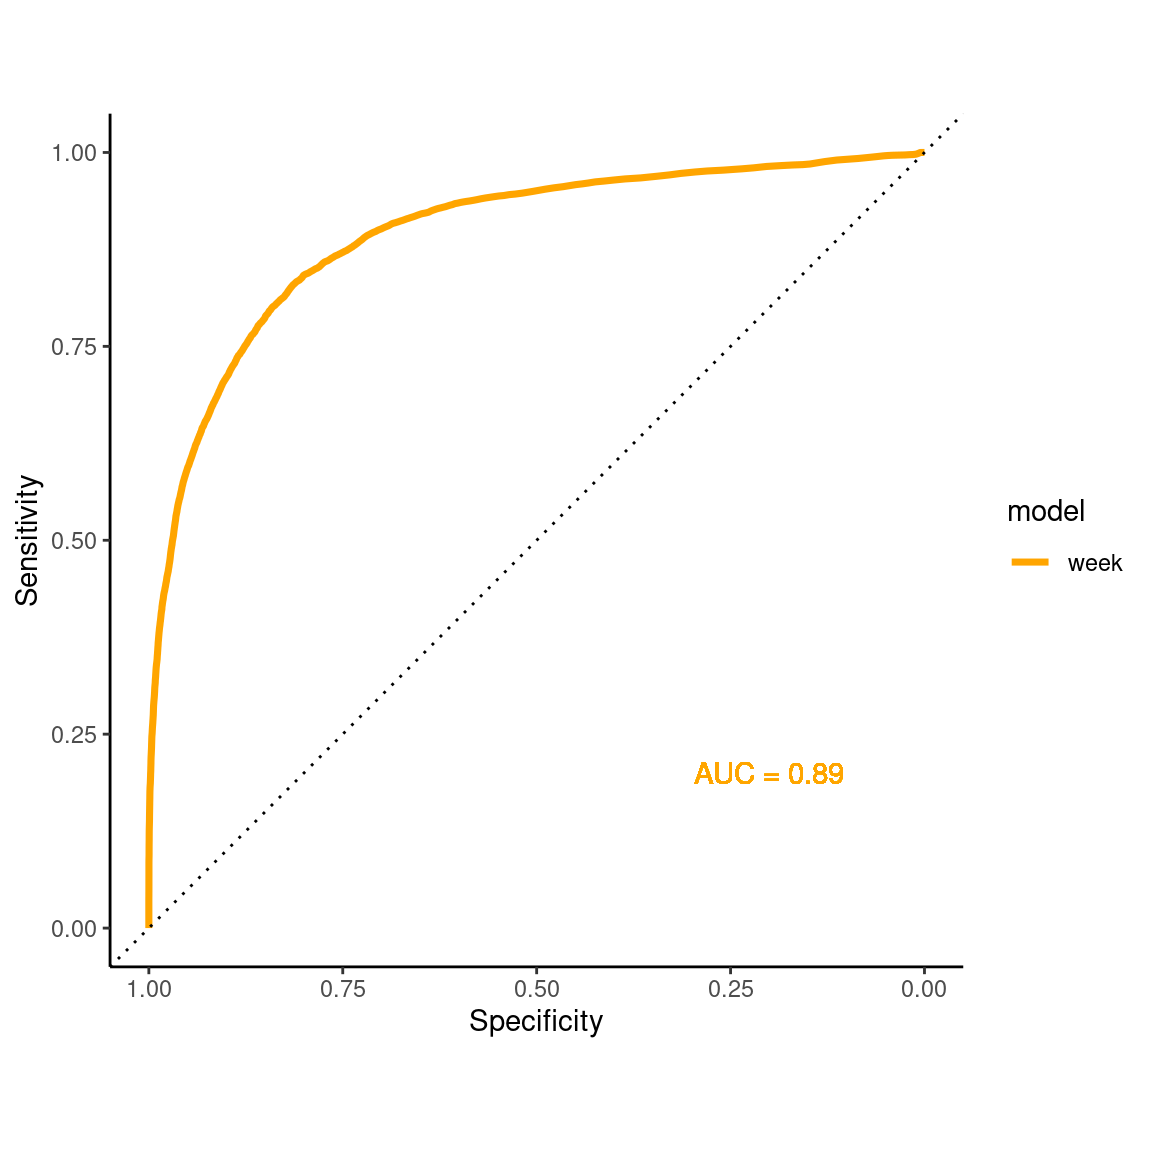

In [ ]:

roc_all |>
  filter(model == "week") |>
  plot_roc() +
  geom_text(x = .80, y = .20,
            label = str_c("AUC = ", auROC_week),
            show.legend = FALSE, color = "orange")


Week & Day

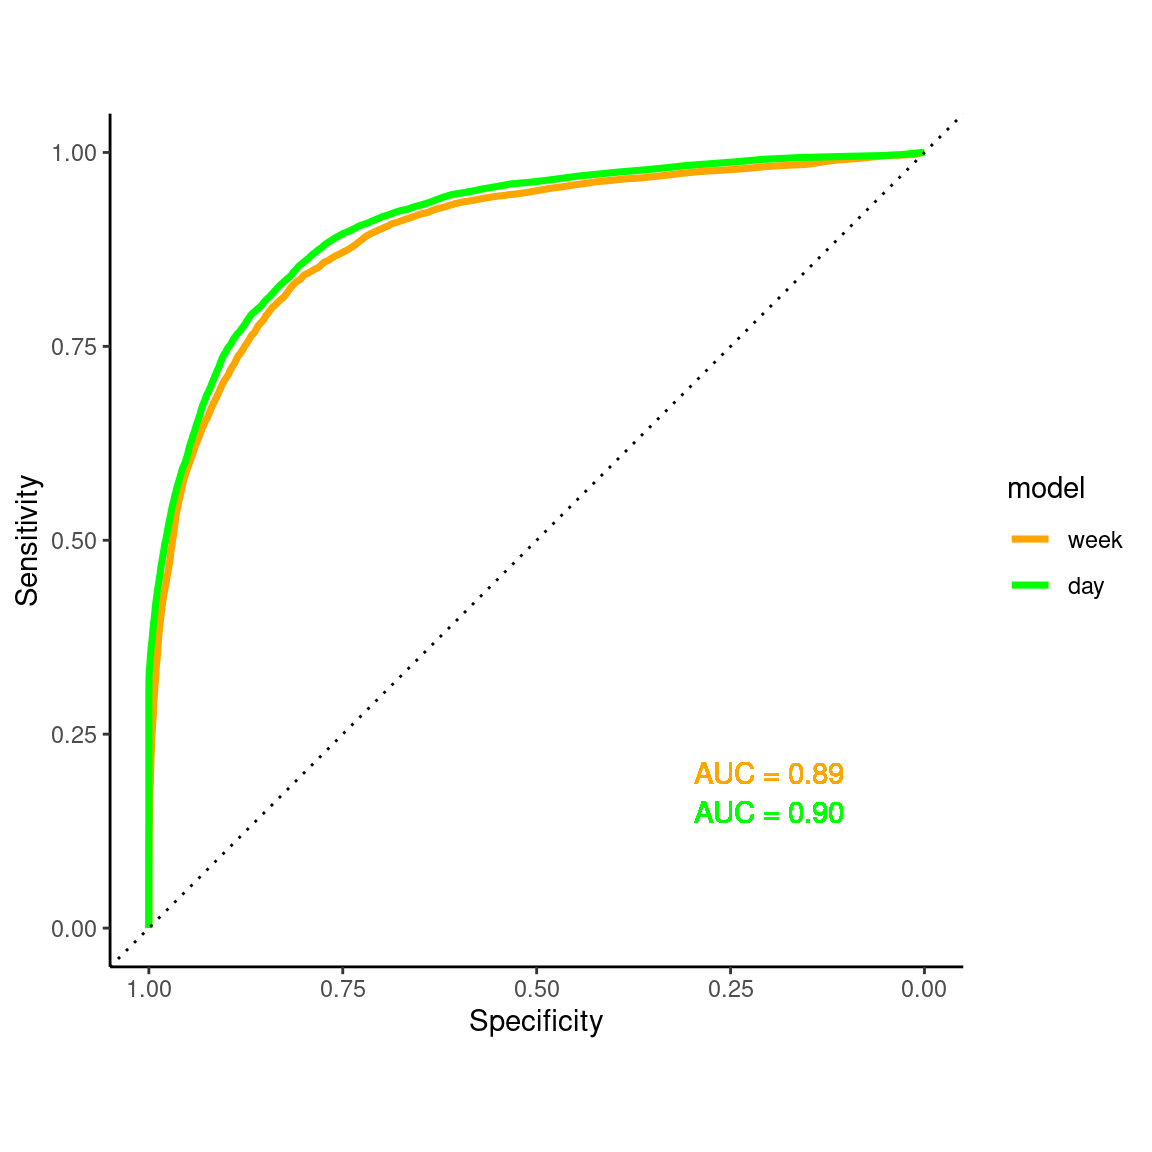

In [ ]:

roc_all |>
  filter(model == "week" | model == "day") |>
  plot_roc() +
  geom_text(x = .80, y = .20,
            label = str_c("AUC = ", auROC_week),
            show.legend = FALSE, color = "orange") +
  geom_text(x = .80, y = .15,
            label = str_c("AUC = ", auROC_day),
            show.legend = FALSE, color = "green")


All three windows

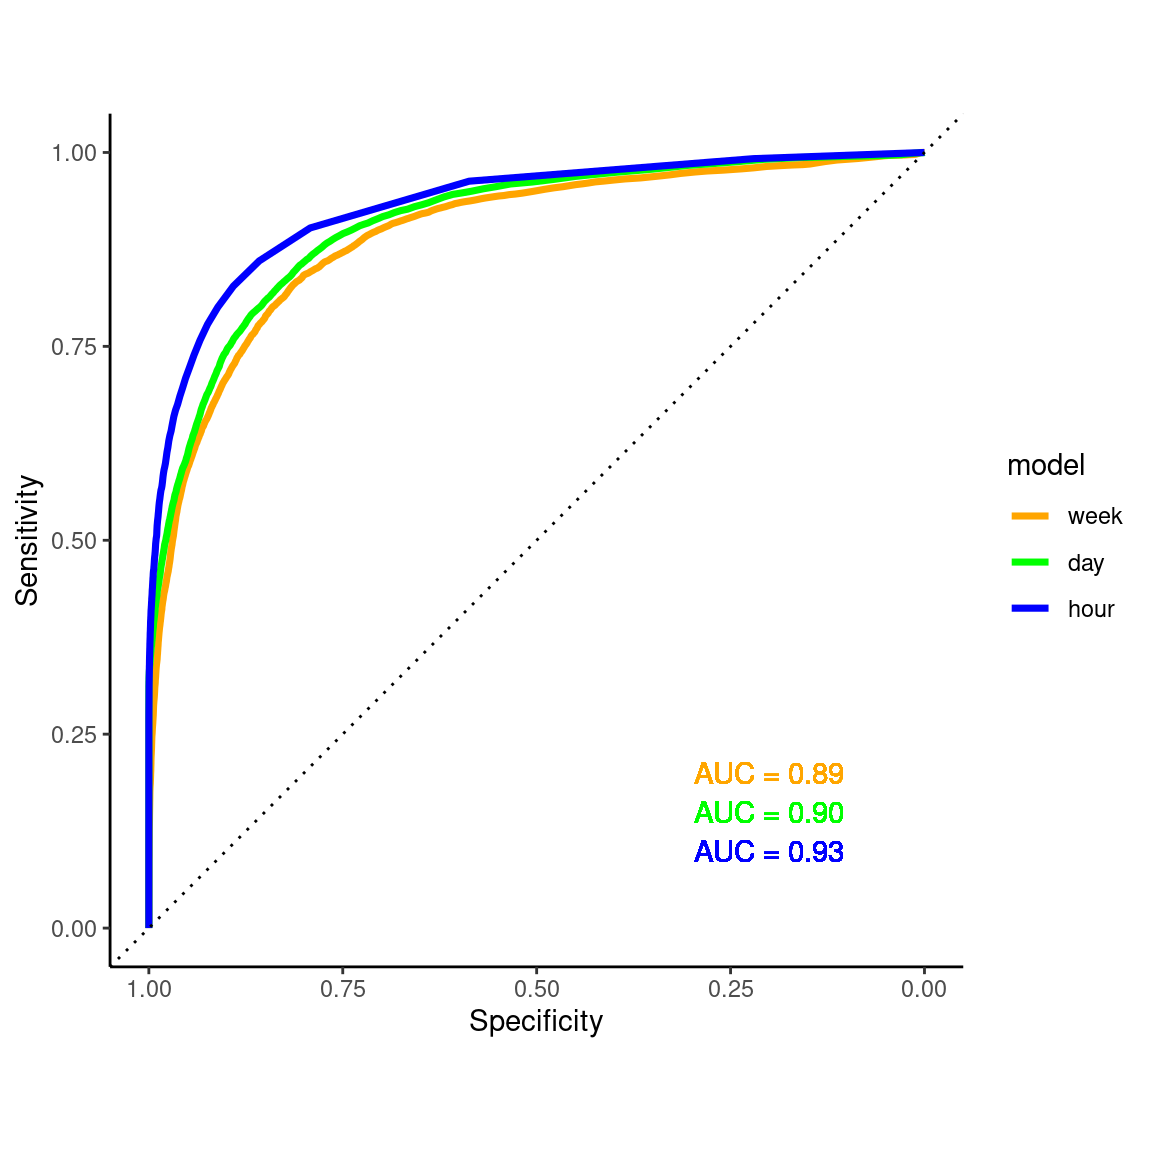

In [ ]:

roc_all |>
  plot_roc() +
  geom_text(x = .80, y = .20,
            label = str_c("AUC = ", auROC_week),
            show.legend = FALSE, color = "orange") +
  geom_text(x = .80, y = .15,
            label = str_c("AUC = ", auROC_day),
            show.legend = FALSE, color = "green") +
  geom_text(x = .80, y = .10,
            label = str_c("AUC = ", auROC_hour),
            show.legend = FALSE, color = "blue")
